## Data 620 - Final Project
### Fall 2017
#### Liam Byrne and Dmitriy Vecheruk
***
### Bitcoin Trading Price and Natural Language Processing

The value of cryptocurrencies, mainly Bitcoin ([BTC](https://coinmarketcap.com/currencies/bitcoin/)), have been extremely volatile since their inception. This volatility is spurred mainly by speculation, rumors and headlines. It would be an interesting use case of Natural Language Processing (NLP) to see how the cryptocurrency markets respond to news, rumor and overall sentiment; let's encapsulate all of these into sentiment for the sake of clarity. The result could be a gradation of the following:

1. Markets react to sentiment - *possible to capitalize on*
2. Sentiment is a reaction to the markets - *no use to capitalize on*
3. There is no correlation to either - *no use to capitalize on*

Moving forward, we will assume that **(1)** from above is how the markets react. In order to analyze this hypothesis, historical trading data from [BitStamp](https://www.bitstamp.net/) due to their medium trading volume. The [Twitter News feed](https://twitter.com/search?l=&q=Bitcoin%20OR%20BTC&src=typd) was scrapped using the search terms `Bitcoin OR BTC` between the dates of April 1, 2017, and December 15, 2017. April 1st was chosen as the starting point of our analysis due to it being the bottom of the market prior to the exponential take-off.

### Data Collection

A script was written, [TwitterBTC_GetData.py](https://github.com/Liam-O/Data620/blob/dev/FinalProject/TwitterBTC_GetData.py) to scrape historical Twitter News using a Twitter scraping package, [got3](https://github.com/Jefferson-Henrique/GetOldTweets-python) and the large trading data from BitStamp ([found here](http://api.bitcoincharts.com/v1/csv/)) was cleaned and substantially trimmed down.

***

### Loading Packages and Data

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from IPython.display import display

# Matplotlib setup
from __future__ import print_function, division
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Plotly setup
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly import tools

# Make plotly work with Jupyter notebook
init_notebook_mode(connected=True)

### Bitcoin Trading Price

In [2]:
# BTC .pkl is on repo under /processed data... must clone to run
processed_path = "processed_data/bitstampUSD_processed_2017.pkl"
btc = pd.read_pickle(processed_path)

# Extract the date, add date time to index and cut out the end of 2016 
btc["date"] = btc.date_time.dt.date
btc.index = btc.date_time

print(btc.shape)
btc.head()

(5803753, 5)


,timestamp,price,volume,date_time,date
date_time,,,,,
2017-03-31 20:00:31-04:00,1491004831,1071.34,0.010045,2017-03-31 20:00:31-04:00,2017-03-31
2017-03-31 20:00:31-04:00,1491004831,1071.34,0.019382,2017-03-31 20:00:31-04:00,2017-03-31
2017-03-31 20:00:52-04:00,1491004852,1070.53,0.029280,2017-03-31 20:00:52-04:00,2017-03-31
2017-03-31 20:00:56-04:00,1491004856,1070.31,0.108770,2017-03-31 20:00:56-04:00,2017-03-31
2017-03-31 20:01:12-04:00,1491004872,1070.93,0.200000,2017-03-31 20:01:12-04:00,2017-03-31


Taking a look at our data, we have ~5.8 million historical trades for BTC in 2017. Below we aggregate this trading data to build an open-high-low-close (OHLC) chart. 

In [3]:
# Add the time aggregation and OHLC funciton
def time_precision(series, precision):
    """
    Returns the date time series with a date time value floored to the 
    specified freq string
    """
    return (pd.DatetimeIndex(series)).floor(precision)


def make_ohlc(df, datetime_col, price_col, time_granularity):
    """
    Calculates the data for an OHLC chart from a df with a date_time and
    price columns, with intervals of time_granularity. Returns a DataFrame.
    """
    
    df = df.sort_values(datetime_col)    
    df["time_bracket"] = df[datetime_col].map(
        lambda x: time_precision(x, time_granularity))

    btc_ohlc = df.groupby("time_bracket")[price_col]\
        .agg(["first", "max", "min", "last", "median"])\
        .rename(columns={'first': 'open', 'max': 'high', "min": "low", "last": "close"})

    conditions = [(btc_ohlc['open'] <= btc_ohlc['close']),
                  (btc_ohlc['open'] > btc_ohlc['close'])]

    choices = ["up", "down"]

    btc_ohlc['price_change_label'] = np.select(conditions, choices)

    btc_ohlc["price_change_pct"] = 100 * \
        (btc_ohlc["close"] / btc_ohlc["open"] - 1)

    return (btc_ohlc)

btc_ohlc_24h = make_ohlc(btc,"date_time","price","1d")
btc_ohlc_6h = make_ohlc(btc,"date_time","price","6h")
btc_ohlc_6h.head(5)

btc = btc.sort_values("timestamp")
df = btc.groupby("date")["price"].agg(['mean']).rename(columns={'mean': 'price'})

start_date = "2017-04-01"
df = btc_ohlc_24h[pd.to_datetime(start_date).date():]

trace = go.Ohlc(x=df.index,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close,
               name = "BTC price")
data = [trace]
layout = dict(title = "Daily BTC price changes since "+start_date,
              yaxis = {'title': 'BTC Price USD'},legend=dict(orientation="h"))
fig = dict(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

We can see the volatility form the daily OHLC charts; from the min on April 1, when the price was ~ \$1K, to December 12, when the price was ~ \$17.5K. Below we will import the Twitter News tweets to venture a comparison between tweets and changing tradin price of Bitcoin. A 12-hour aggregated time interval will be used in order to make a comparison; specifically by the price change differential. An example of this BTC data is below.

In [4]:
time_aggr = "12h" ## Definition of the used time precision!
btc_ohlc = make_ohlc(btc,"date_time","price",time_aggr)
btc_ohlc.head(5)

,open,high,low,close,median,price_change_label,price_change_pct
time_bracket,,,,,,,
2017-03-31 12:00:00-04:00,1071.34,1076.84,1065.61,1069.15,1070.15,down,-0.204417
2017-04-01 00:00:00-04:00,1069.15,1097.00,1065.50,1073.65,1083.74,up,0.420895
2017-04-01 12:00:00-04:00,1073.68,1085.00,1061.64,1074.77,1073.04,up,0.101520
2017-04-02 00:00:00-04:00,1074.77,1089.00,1066.49,1089.00,1076.58,up,1.324004
2017-04-02 12:00:00-04:00,1089.00,1120.50,1071.12,1120.50,1088.00,up,2.892562


## Twitter News

Twitter News was used instead of the normal tweets due to a large volume of tweets from bots and tweets that seemed to be from scammers of marketers. Up to 1000 tweets/day were scrapped in order to analyze sentiment in order to collect enough tweets over a time-frame to compare it to the trading price of BTC as the results were returned with a mixture of popularity and most recent.

In [5]:
# Previous file used was "data/tweets2017.csv", the normal twitter feed
twt_path = "data/tweetnews_2017.csv"
twt = pd.read_csv(twt_path, encoding = "ISO-8859-1")
twt = twt.sort_values("timestamp")
twt["timestamp"] = pd.to_datetime(twt["timestamp"])
twt = twt[twt["timestamp"]>= pd.to_datetime("2017-01-01")]
print(twt.shape)
twt.head(10)

(182789, 2)


,tweet,timestamp
130,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05
129,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19
128,????????? Bitcoin ?Monacoin?????? - NAVER ??? ...,2017-03-31 21:04:50
127,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49
126,How an Anarchist Bitcoin Coder Found Himself F...,2017-03-31 21:51:09
125,Federal Reserve official warns of digital curr...,2017-03-31 22:08:03
124,Bitcoin : 'Blood Diamonds' Of The Digital Era ...,2017-03-31 22:13:59
123,A Plan to Save Blockchain Democracy From Bitco...,2017-03-31 22:18:00
122,Digital asset exchange ShapeShift raises $10.4...,2017-03-31 22:30:18
121,How Anarchist Bitcoin Coder Amir Taaki Wound U...,2017-03-31 22:32:14


Taking a closer look at some random tweets we see that a lot of them are stories of recent developments, marketing spam and rumor.

In [6]:
for t in twt.tweet[np.random.randint(0, len(twt), 10)]:
    print("\n"+t)


Bitcoin 's murkier rivals line up to displace it as cybercriminals' favorite http:// ift.tt/2q0Dubb Find me on http://www. briercliffe.com

Bitcoin rally keeps going; tops $2,200 $ COIN $ BTCS http://www. seekingalpha.com/news/3269178

One reason for the Bitcoin price spike? Increasing interest from institutional investors. http:// nyti.ms/2j5VOSK

The Uncertain Future of Bitcoin Futures http:// fb.me/3vgTPbNoL

Wall Street's 'dean of valuation' says digital currencies are replacing gold http://www. cnbc.com/2017/07/18/wal l-streets-dean-of-valuation-says-digital-currencies-replacing-gold.html  #Bitcoin #gold #WallStreet

JPMorgan's Marko Kolanovic Joins His Boss in Bashing Bitcoin https://www. bloomberg.com/news/articles/ 2017-09-13/jpmorgan-s-gandalf-kolanovic-joins-boss-in-bashing-bitcoin  via @markets

#Bitcoin gained nearly 600% this year, and its price has doubled from as recently as mid-September #News #GoWirex http:// money.cnn.com/2017/11/13/inv esting/bitcoin-price-volatil

The tweets contain a lot of urls, different languages and repeat spams of tweets. We will clean the tweets in the following process and see the results of a randomized sample.

In [7]:
def isEnglish(s):
    """Checks if a string contains ASCII characters only.
    Source: https://stackoverflow.com/a/27084708/8066374
    """
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
# Clean the tweets
twt["tweet_proc"] = twt["tweet"].str.replace("https?://.*","") # remove all urls
twt["tweet_proc"] = twt["tweet_proc"].str.replace("’|","") # remove non-unicode apostrophe
twt = twt[twt["tweet_proc"].str.len() >= 3] # retain only the tweets with more than 3 remaining characters
twt["is_english"] = twt["tweet_proc"].map(isEnglish)

for t in twt.tweet_proc[np.random.randint(0, len(twt), 10)]:
    print("\n"+t)


Crazy. " Bitcoin rockets above $7,000 for the first time" 

NYTimes: What Is Bitcoin , and How Does It Work? 

Le bitcoin résiste à la création du bitcoin cash : 

Get ready. Bitcoin bringing massive innovation to how charities track, measure and report gifts. 

Cryptocurrency Mania Goes Beyond Bitcoin 

Bitcoin Futures Could Open the Floodgates for Institutional Investors Read more: 

Bitcoin mining heats homes for free in Siberia 

Blockchain Technology Applications & Use Cases - 

1.1 - #Bitcoin : la communauté nen finit pas de se diviser | L'Opinion 

#bitcoin to hit $20,000 by December 2018 investor #digitalgold #investing #video 


As a final cleaning process, we will remove non-English tweets and drop duplicates prior to our sentiment analysis.

In [8]:
twt.groupby(["is_english"])["tweet"].count()

is_english
False     32086
True     147268
Name: tweet, dtype: int64

Remove ~32K tweets with non-ASCII characters to prepare the data for VADER sentiment analysis

In [9]:
twt_clean = twt[twt["is_english"]==True]
twt_clean = twt_clean.drop_duplicates("tweet_proc")
twt_clean = twt_clean.reset_index(drop = True)
twt_clean.shape

(79594, 4)

Only ~80k tweets remain after the cleaning step

#### Extract sentiment using NLTK and VADER

We will get the sentiment of the tweets regarding Bitcoin using the [Valence Aware Dictionary and sEntiment Reasoner (VADER) package](https://github.com/cjhutto/vaderSentiment). It gives a negative, neutral and compound score based on the tweets. We will look at some output to get an idea of how it works.

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

for t in twt.tweet_proc[np.random.randint(0, len(twt), 10)]:
    print("{}:\n{}\n".format(t, sid.polarity_scores(t)))

#Bitcoin and Ether prices hit all-time high :
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Bitcoin se dispara a máximo histórico de 6 mil dólares - Grupo Milenio :
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Bitcoin is giving OSTK a huge boost.$ BTC :
{'neg': 0.0, 'neu': 0.515, 'pos': 0.485, 'compound': 0.5719}

Bitcoin price hits $7,000 for the first time :
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

THE BOTTOM LINE: A top Wall Street strategist says there's nothing to worry about and we examine bitcoin 's surge :
{'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'compound': 0.4949}

$ BTCUSD Heres a reason why China would want to shut down #bitcoin :
{'neg': 0.0, 'neu': 0.885, 'pos': 0.115, 'compound': 0.0772}

Best explanation yet! Bitcoin isn't money  it's a 'censorship-resistant asset class' :
{'neg': 0.0, 'neu': 0.534, 'pos': 0.466, 'compound': 0.7901}

BBC News - Bitcoin swings as civil war looms :
{'neg': 0.478, 'neu': 0.522, 'pos': 0.0, 'compound': -0.

In [11]:
# Append sentiment to tweets
twt_clean["sid"] = twt_clean["tweet_proc"].map(lambda x: sid.polarity_scores(x))
twt_clean = pd.concat([twt_clean.drop(["sid","tweet","is_english"], axis=1), 
                       twt_clean["sid"].apply(pd.Series)], axis=1)

#### Visualize the daily sentiment over time

Like the BTC trading data. We will aggregate the tweets over a 12 hour interval. We will plot the resulting time series. We aggregated the sentiment so the positive negative volume of sentiment could be reflected.

In [12]:
# Extract time components 
twt_clean["date_time"] = pd.to_datetime(twt_clean["timestamp"])

# Add the time granularity required for the join with the price data
twt_clean["time_bracket"] = (pd.DatetimeIndex(twt_clean["date_time"],
                                              tz = "America/New_York",
                                              ambiguous=False)).floor(time_aggr)

# Get daily total for the VADER scores
twt_clean_agg = twt_clean[["time_bracket","neg","pos","compound"]].groupby(["time_bracket"]).sum()
twt_clean_agg.head()

,neg,pos,compound
time_bracket,,,
2017-03-31 12:00:00-04:00,0.849,0.455,-0.8425
2017-04-01 00:00:00-04:00,3.317,4.314,2.2174
2017-04-01 12:00:00-04:00,2.051,2.809,1.2779
2017-04-02 00:00:00-04:00,1.928,1.762,-0.6084
2017-04-02 12:00:00-04:00,1.815,3.636,3.1380


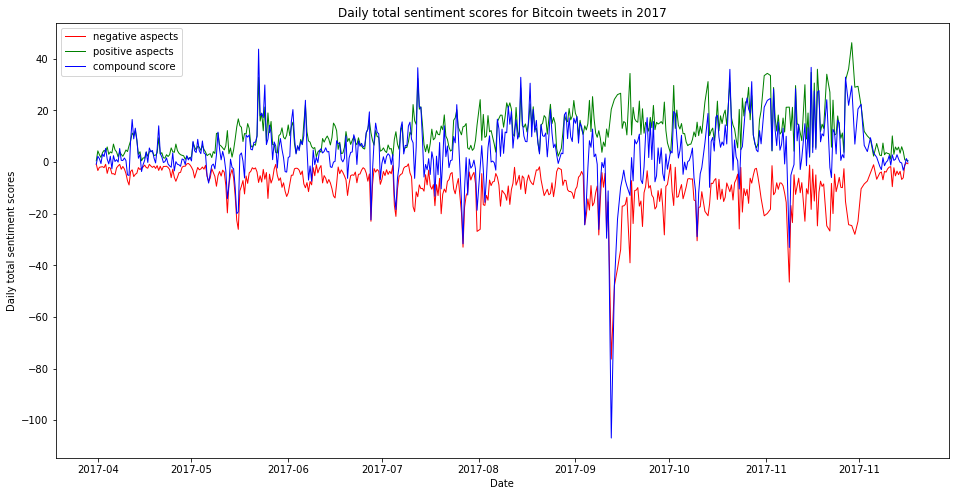

In [13]:
# Make a line plot
df = twt_clean_agg

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, -df["neg"], linewidth=1,
         color="red", label=r"negative aspects")
plt.plot(df.index, df["pos"], linewidth=1,
         color="green", label=r"positive aspects")
plt.plot(df.index, df["compound"], linewidth=1,
         color="blue", label=r"compound score")
plt.xlabel(r"Date")
plt.ylabel(r"Daily total sentiment scores")
plt.title(r"Daily total sentiment scores for Bitcoin tweets in 2017")


# plt.plot(btc_daily_avg["date"], btc_daily_avg["price"], linewidth=1,
#          color="blue", label=r"daily avg price")

plt.legend(loc="upper left")

plt.show()

#### Correlate the daily compound sentiment with the price change direction

In [14]:
# Sentiment differential
twt_clean_agg["sent_diff"] = 0.0

for s in range(1, len(twt_clean_agg.index)):
    twt_clean_agg["sent_diff"][s] = np.float(twt_clean_agg["compound"][s]-twt_clean_agg["compound"][s-1])
    
twt_clean_agg.head()

,neg,pos,compound,sent_diff
time_bracket,,,,
2017-03-31 12:00:00-04:00,0.849,0.455,-0.8425,0.0000
2017-04-01 00:00:00-04:00,3.317,4.314,2.2174,3.0599
2017-04-01 12:00:00-04:00,2.051,2.809,1.2779,-0.9395
2017-04-02 00:00:00-04:00,1.928,1.762,-0.6084,-1.8863
2017-04-02 12:00:00-04:00,1.815,3.636,3.1380,3.7464


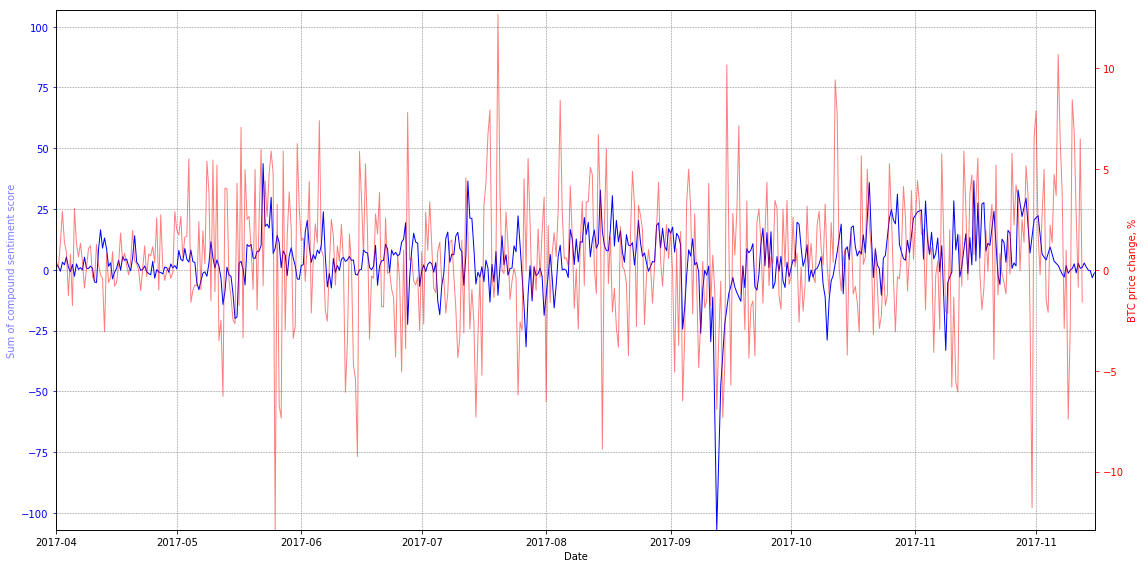

In [15]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

import datetime
#Zoom timeline
format = '%Y-%m-%d %H:%M:%S'
start = datetime.date(2017, 4, 1) #enter 'None' to see all left
end = datetime.date(2017, 12, 16) #enter 'None' to see all right

#Variables
twt_var = "compound"#"sent_diff"
btc_var = "price_change_pct"#close
df1 = df1[(df1.index >= pd.to_datetime(start)) & (df1.index <= pd.to_datetime(end))]
df2 = df2[(df2.index >= pd.to_datetime(start)) & (df2.index <= pd.to_datetime(end))]

#Force same y
twt_lim = max(abs(df1[twt_var]))
btc_lim = max(abs(df2[btc_var]))


fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(df1.index, df1[twt_var], linewidth=1,color="blue")
ax1.set_xlabel('Date')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Sum of compound sentiment score', color='blue', alpha = 0.5)
ax1.tick_params('y', colors='blue')
ax1.grid(color='grey', linestyle='--', linewidth=.5)
ax1.set_ylim(-twt_lim, twt_lim)
ax1.set_xlim(left = start, right = end)
#ax1.set_yscale("log", nonposy='clip')

ax2 = ax1.twinx()

ax2.plot(df2.index, df2[btc_var], linewidth=1,color="red", alpha = 0.5)
ax2.set_ylabel('BTC price change, %', color='red')
ax2.tick_params('y', colors='red')
ax2.set_xlim(left = start, right = end)
ax2.set_ylim(-btc_lim, btc_lim)
#ax2.set_yscale("log", nonposy='clip')

# ax3 = ax1.twinx()
# ax3 = ax1.twiny()
# ax3.plot(twt_clean_daily.index,np.repeat(0,len(twt_clean_daily.index)),
#          linewidth=1,color="black")

fig.tight_layout()
plt.show()

In [25]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

import datetime
'''
#Zoom timeline
format = '%Y-%m-%d %H:%M:%S'
start = datetime.date(2017, 4, 1) #enter 'None' to see all left
end = datetime.date(2017, 12, 16) #enter 'None' to see all right
'''
#Variables
twt_var = "compound"#"sent_diff"
btc_var = "price_change_pct"#close
'''
df1 = df1[(df1.index >= pd.to_datetime(start)) & (df1.index <= pd.to_datetime(end))]
df2 = df2[(df2.index >= pd.to_datetime(start)) & (df2.index <= pd.to_datetime(end))]
'''
#Force same y
twt_lim = max(abs(df1[twt_var]))
btc_lim = max(abs(df2[btc_var]))

trace1 = go.Scatter(x = df1.index, y = df1[twt_var], name = "sent")
trace2 = go.Scatter(x = df2.index, y = df2[btc_var], name = "btc", yaxis = "y2")

plot_data = [trace1, trace2]

layout = go.Layout(
    title='Twitter Sentiment and BTC Price',
    yaxis=dict(
        title='Sentiment',
        range = [-abs(max(df1[twt_var])),abs(max(df1[twt_var]))]
    ),
    yaxis2=dict(
        title='BTC price change (%)',
        range = [-abs(max(df2[btc_var])),abs(max(df2[btc_var]))],
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
    
fig = go.Figure(data = plot_data, layout = layout)
iplot(fig, filename = 'btc_sent')

In the chart above we can see that the blue line (overall sentiment of the tweets about Bitcoin) often follows the red line (change in the Bitcoin price vs. the previous day) with a small time lag. This would indicate that Twitter sentiment (at least in our dataset) is reactive to changes in the BTC price.

In [26]:
print(btc_ohlc.head(1))
print(twt_clean_agg.head(1))

                              open     high      low    close   median  \
time_bracket                                                             
2017-03-31 12:00:00-04:00  1071.34  1076.84  1065.61  1069.15  1070.15   

                          price_change_label  price_change_pct  
time_bracket                                                    
2017-03-31 12:00:00-04:00               down         -0.204417  
                             neg    pos  compound  sent_diff
time_bracket                                                
2017-03-31 12:00:00-04:00  0.849  0.455   -0.8425        0.0


In [27]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

btc_twt = pd.merge(df2.reset_index(),df1.reset_index(),"left")
btc_twt.shape

(512, 12)

In [28]:
# Check the periods with missing Twitter data
btc_twt[btc_twt.pos.isnull()].shape

(30, 12)

### Add features for price change in the previous and past period

In [29]:
btc_twt["price_change_pct_prev_period"] = btc_twt["price_change_pct"].shift(1)
btc_twt["price_change_pct_next_period"] = btc_twt["price_change_pct"].shift(-1)
btc_twt.head(3)

,time_bracket,open,high,low,close,median,price_change_label,price_change_pct,neg,pos,compound,sent_diff,price_change_pct_prev_period,price_change_pct_next_period
0,2017-04-01 00:00:00-04:00,1069.15,1097.0,1065.50,1073.65,1083.74,up,0.420895,3.317,4.314,2.2174,3.0599,NaN,0.101520
1,2017-04-01 12:00:00-04:00,1073.68,1085.0,1061.64,1074.77,1073.04,up,0.101520,2.051,2.809,1.2779,-0.9395,0.420895,1.324004
2,2017-04-02 00:00:00-04:00,1074.77,1089.0,1066.49,1089.00,1076.58,up,1.324004,1.928,1.762,-0.6084,-1.8863,0.101520,2.892562


### There are some days with no tweets in our dataset: decide what to do - remove or impute!

In [30]:
# Filter out the days with no twitter sentiment
btc_twt = btc_twt[btc_twt["compound"].notnull()]
btc_twt.shape

(482, 14)

221 daily observations remain if NaN twitter days are ignored

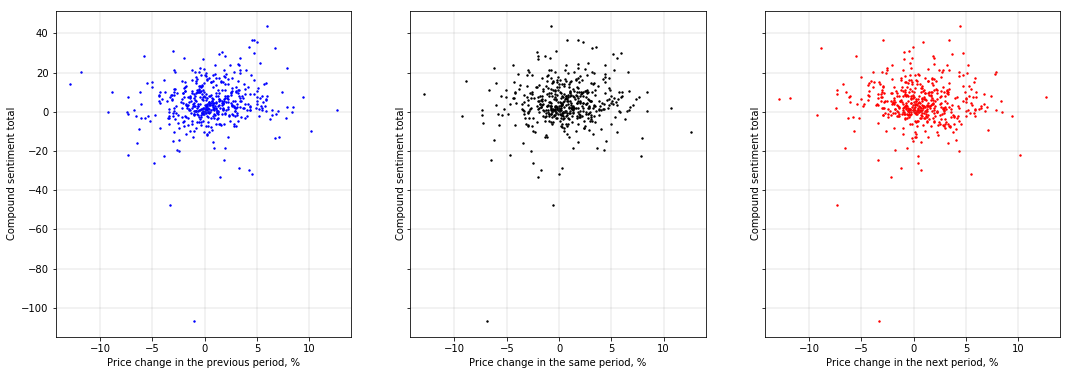

In [31]:
df = btc_twt

# fig, ax1 = plt.subplots(figsize=(8, 8))
fig, ((ax3, ax1, ax2)) = plt.subplots(1,3, sharex=True, sharey=True,figsize=(18, 6))

#Twitter variable
twt_var = "compound"
# axis label
twt_axis_label = dict(sent_diff = "Sentiment score change vs. past period",
                     compound = "Compound sentiment total")


ax1.scatter(df["price_change_pct"], df[twt_var], color="black",s=2)
ax1.set_xlabel('Price change in the same period, %')
ax1.set_ylabel(twt_axis_label[twt_var])
ax1.grid(color='grey', linestyle='-', linewidth=0.2)

ax2.scatter(df["price_change_pct_next_period"], df[twt_var], color="red",s=2)
ax2.set_xlabel('Price change in the next period, %')
ax2.set_ylabel(twt_axis_label[twt_var])
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax3.scatter(df["price_change_pct_prev_period"], df["compound"], color="blue",s=2)
ax3.set_xlabel('Price change in the previous period, %')
ax3.set_ylabel(twt_axis_label[twt_var])
ax3.grid(color='grey', linestyle='-', linewidth=0.2)

plt.show()

### Check the correlations

In [32]:
correlations = btc_twt[["price_change_pct_prev_period","price_change_pct","price_change_pct_next_period",
         "sent_diff","compound","pos","neg"]].corr()

correlations.iloc[0:3,3:]

,sent_diff,compound,pos,neg
price_change_pct_prev_period,0.039145,0.107238,0.080822,-0.009726
price_change_pct,0.114288,0.089670,0.014326,-0.056928
price_change_pct_next_period,0.038748,-0.003285,-0.019471,-0.015318


We can see that the highest correlations between the price variables and sentiment variables are achieved between:
  
* the compound sentiment in the current period and the price change vs. the past period (r = +0.164)
* the change in sentiment and the price change vs. the past period (r = +0.116)

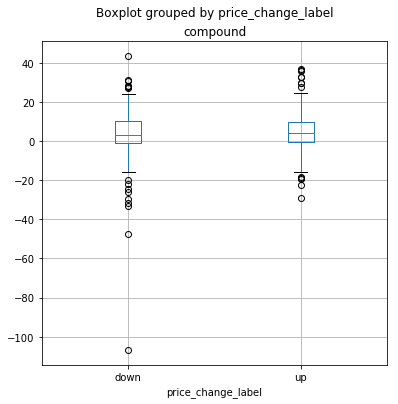

In [33]:
btc_twt.boxplot(column=twt_var,by='price_change_label',figsize=(6, 6))

### Next steps
  
Dima  
1. Get numeric feature for the price (rolling X hours) - daily and time-period (make function)

Liam
2. Get more Twitter data (to close the days with the gaps) - try switching off Top Tweets
3. Get more Twitter data - from "news" 

Tomorrow
4. Inspect correlations between sentiment and price response (also time-shifted)
5. Maybe - if we see correlation - come up with a model to predict the response

Optional
1. Word frequency distribution from the tweets (also separately for positive and negative tweets)

### Word Frequency Analysis

Look at high frequency words when the price differential is large, to see if the could be word usage signals to buy or sell.

In [34]:
# Get 1000 largest price differences since 2017/4/1
btc_large_diff = btc_ohlc[pd.to_datetime("2017-04-01").date():]
btc_large_diff["abs_price_change_pct"] = btc_large_diff["price_change_pct"].abs()
btc_large_diff = btc_large_diff.nlargest(100, "abs_price_change_pct")

#Get start time of time frame
btc_large_diff["timestart"] = [t.replace(tzinfo = None) for t in btc_large_diff.index]

In [35]:
btc_large_diff.head()

,open,high,low,close,median,price_change_label,price_change_pct,abs_price_change_pct,timestart
time_bracket,,,,,,,,,
2017-05-25 12:00:00-04:00,2686.02,2693.38,2221.00,2340.01,2398.99,down,-12.881885,12.881885,2017-05-25 12:00:00
2017-07-20 00:00:00-04:00,2324.99,2665.99,2303.20,2619.17,2529.00,up,12.652958,12.652958,2017-07-20 00:00:00
2017-11-30 00:00:00-05:00,10511.52,10581.95,9000.00,9273.72,9715.66,down,-11.775652,11.775652,2017-11-30 00:00:00
2017-12-06 12:00:00-05:00,12649.90,14095.00,12637.29,13999.00,13482.40,up,10.664906,10.664906,2017-12-06 12:00:00
2017-09-15 00:00:00-04:00,3359.95,3712.92,2972.01,3701.30,3267.13,up,10.159377,10.159377,2017-09-15 00:00:00


In [36]:
len(btc_ohlc_6h)

1025

In [ ]:
twt_clean["future_price_diff"] = np.NaN

#Get future price change for respective tweet, if applicable
for t in twt_clean.index:
    if (btc_large_diff.timestart - twt_clean.date_time[t] <= pd.Timedelta('6 hours')).any():
        twt_clean["future_price_diff"][t] = btc_large_diff.price_change_pct[
            btc_large_diff.timestart - twt_clean.date_time[t] <= pd.Timedelta('6 hours')][0]

# Drop NaNs
twt_large_diff = twt_clean.dropna()

In [ ]:
twt_large_diff.head()

In [ ]:
len(twt_large_diff)

We add domain-specific stop words to exclude from the frequency analysis (synonyms for "bitcoin" and the Twitter-specific term "RT" for retweet).

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *

domain_stop_words = ["bitcoin","btc","blockchain","cryptocurrency","currency","new","digital","rt"]

stop_words = set(nltk.corpus.stopwords.words('german') +\
           nltk.corpus.stopwords.words('english') + domain_stop_words)

twt_diff_up = twt_large_diff[twt_large_diff.future_price_diff > 0]
twt_diff_down = twt_large_diff[twt_large_diff.future_price_diff < 0]

# Clean then tokenize tweets. Also, remove stop words
# For "up" related tweets

twt_tokens_up = [nltk.tokenize.word_tokenize(t)
              for t in twt_diff_up["tweet_proc"].str.lower().replace(r'[^a-z\s]+','',regex=True)]
vocab_up = [item for sublist in twt_tokens_up for item in sublist if item not in stop_words]
fdist_up = nltk.FreqDist(vocab_up)

# For "down" related tweets
twt_tokens_down = [nltk.tokenize.word_tokenize(t)
              for t in twt_diff_down["tweet_proc"].str.lower().replace(r'[^a-z\s]+','',regex=True)]
vocab_down = [item for sublist in twt_tokens_down for item in sublist if item not in stop_words]
fdist_down = nltk.FreqDist(vocab_down)

def top_bigrams(vocab,n):
    """
    Calculates the top n most frequent bigrams 
    in the vocabulary. Returns a sorted list with bigram and
    normalized frequency.
    """
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    word_fd = nltk.FreqDist(vocab)
    bigram_fd = nltk.FreqDist(nltk.bigrams(vocab))
    finder = BigramCollocationFinder(word_fd, bigram_fd)
    scored = finder.score_ngrams(bigram_measures.raw_freq)
    
    return([(" ".join(bigram),score) for bigram,score in scored[:n]])   

def make_freq_df(list_of_tuples):
    """Makes a Pandas DF from an output of FreqDist"""
    
    df = pd.DataFrame(list_of_tuples,columns=["token","frequency"])
    df["tf"] = df["frequency"]/df["frequency"].max()
    df["prob"] = df["frequency"]/df.shape[0]
    
    return(df)

In [ ]:
# Need to normalize by vocab length or by the % of the maximum
print(len(twt_tokens_up), len(twt_tokens_down))

In [ ]:
print(fdist_up.most_common(20),)

In [ ]:
top_bigrams(vocab_up,10)

In [ ]:
freq_up = make_freq_df(fdist_up.most_common())
freq_down = make_freq_df(fdist_down.most_common())

In [ ]:
freq_up[:10]

In [ ]:
freq_down[:10]

In [ ]:
# Make a chart with top words associated with UP and DOWN

df1 = freq_up[:20].sort_values("prob",ascending=True)
df2 = freq_down[:20].sort_values("prob",ascending=True)
x = "prob"
y = "token"
text = x

trace1 = go.Bar(
            x=df1[x],
            y=df1[y],
            text= (df1[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(0,255,120,0.5)',
            ),
            orientation = 'h',
            name = "Price increased"
        )
trace2 = go.Bar(
            x=df2[x],
            y=df2[y],
            text=(df2[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(255,0,0,0.5)',
            ),
            orientation = 'h',
            name = "Price decreased"
        )

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=900, title='Top terms associated with BTC price increase/decrease \
<br>(sorted by relative frequency of ocurrence in tweets)',
                     legend=dict(orientation="h"))
fig['layout']["yaxis1"].update(tickfont=dict(size=14))
fig['layout']["yaxis2"].update(tickfont=dict(size=14))

iplot(fig, filename='simple-subplot')

In [ ]:
# Make a chart with top bigrams
up_bigrams = make_freq_df(top_bigrams(vocab_up,20))
down_bigrams = make_freq_df(top_bigrams(vocab_down,20))

In [ ]:
df1 = up_bigrams[:20].sort_values("frequency",ascending=True)
df2 = down_bigrams[:20].sort_values("frequency",ascending=True)
x = "frequency"
y = "token"
text = x

trace1 = go.Bar(
            x=df1[x],
            y=df1[y],
            text= (df1[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(0,255,120,0.5)',
            ),
            orientation = 'h',
            name = "Price increased"
        )
trace2 = go.Bar(
            x=df2[x],
            y=df2[y],
            text=(df2[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(255,0,0,0.5)',
            ),
            orientation = 'h',
            name = "Price decreased"
        )

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=900, title='Top terms associated with BTC price increase/decrease\
<br>(sorted by relative frequency of ocurrence in tweets)',
                     legend=dict(orientation="h"),margin=dict(l=120))
fig['layout']["yaxis1"].update(tickfont=dict(size=14))
fig['layout']["yaxis2"].update(tickfont=dict(size=14))

iplot(fig, filename='simple-subplot')

### Reference

https://pandas.pydata.org/pandas-docs/stable/index.html  
http://mple.m-artwork.eu/tutorial  
Pandas Ifelse selection https://stackoverflow.com/a/19913845/8066374  
NLTK & Vader http://www.nltk.org/howto/sentiment.html  
Pandas dict to columns https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns  
Matplotlib multiple axes https://matplotlib.org/examples/api/two_scales.html  
Bigram analysis in NLTK http://www.nltk.org/howto/collocations.html  
Plotly Reference https://plot.ly/python/